In [1]:
from kafka import KafkaConsumer
import pandas as pd
from json import dumps
import numpy as np
import pickle
from sklearn.metrics import classification_report,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [2]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)



In [3]:
for m in consumer:
    print(m.value)
    break

b'"54:22.4,27,10,0,10,11,2.767194749,6,6,7,3.666666667,2,192,14,1,1\\n"'


In [4]:
S_dataset= pd.read_csv("static.csv")

In [5]:
S_dataset.shape

(268074, 15)

In [6]:
S_dataset.head()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,15,9,0,11,0,2.929439,4,3,5,4.333333,2,192,15,1,1


In [7]:
def batch_record(itr):
    list_with_1000_record=[]
    i=0
    for m in consumer:
        
        if i <1000:
            list_with_1000_record.append(m.value)
            i=i+1
        else:
            
            break
    print(f"Window {itr}")
   
    
    return list_with_1000_record        
        

In [8]:
column_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
def preparation( data):
    df=pd.DataFrame()
    list_of_row=[]
    for item in data:
        row_string=eval(item.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        list_of_row.append(row)
    df=pd.DataFrame(list_of_row)
    df.columns=column_names
    return df
 

In [9]:
def data_cleaning(data):
    data['longest_word'] = data['longest_word'].replace(r'(([a-z]+)|([A-Z]+)|'')',2, regex=True)
    data['longest_word'].fillna(2,inplace=True)
    data['sld'] = data['sld'].replace(r'(([a-z]+)|([A-Z]+|(0-1)))',192, regex=True)
    data['sld']=data['sld'] .astype('int') 
    data.drop('timestamp', inplace=True, axis=1)
    return data.astype('float')
 

In [10]:
def Normalize(df):
    df_max_scaled=df
    for column in df_max_scaled.columns:
        df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max()
    return df_max_scaled

In [11]:
best_features=['FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric', 'special', 'labels', 'sld']

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
def Pretrained_model(data):
    X =data.drop(labels = ["Target Attack"], axis=1) 
    y=data["Target Attack"] 
#     X_normalize=Normalize(X)
#     X_normalize_feat= X_normalize[best_features]
    DT = DecisionTreeClassifier()
    # Fit the model
    #DT.fit(X_normalize_feat,y)
    return DT.fit(X[best_features],y)

In [14]:
static =pickle.load(open('finalized_model.sav', 'rb'))
Dynamic= pickle.load(open('finalized_model.sav', 'rb'))

In [15]:
# len(ACC_static)
Dynamic

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5)

In [16]:
S_dataset.shape

(268074, 15)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
ACC_Dynmaic=[]
ACC_static=[]
for itr in range(1,250):
    r_dataset = batch_record(itr)
    p_dataset =  preparation(r_dataset)
    new_dataset =  Normalize(data_cleaning(p_dataset))
    
    S_dataset=Normalize(S_dataset).append(new_dataset)
    X =new_dataset.drop(labels = ["Target Attack"], axis=1) 
    y=new_dataset["Target Attack"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    new_dataset.append(S_dataset)
    #Dynamic=Dynamic.fit(X_train[best_features],y_train)
    Dy_pred=Dynamic.predict(X[best_features])
    D_acc=accuracy_score(y,Dy_pred)
    print(f"Dynamic Model accuracy without retrain = {D_acc*100}%")
    if D_acc < 0.83 :

        print(" The model will train on the new data")
        Dynamic_model=Pretrained_model(new_dataset)
        Dy_pred=Dynamic_model.predict(X[best_features])
        D_acc=accuracy_score(y,Dy_pred)
        print(f"Dynamic Model accuract after pretrain = {D_acc*100}%")
    #static=static.fit(X_train[best_features],y_train)
    Sy_pred=static.predict(X[best_features])
    S_acc=accuracy_score(y,Sy_pred)
    print(f"ACC of Static Model = {S_acc*100}%")
    ACC_Dynmaic.append(D_acc)
    ACC_static.append(S_acc)
    print(f"{'='*40}")
   

Window 1
Dynamic Model accuracy without retrain = 81.3%
 The model will be trained on the new data
ACC of Dynamic Model after retrain = 81.6%
ACC of Static Model = 81.3%
Window 2
Dynamic Model accuracy without retrain = 81.2%
 The model will be trained on the new data
ACC of Dynamic Model after retrain = 81.39999999999999%
ACC of Static Model = 81.2%
Window 3
Dynamic Model accuracy without retrain = 68.7%
 The model will be trained on the new data
ACC of Dynamic Model after retrain = 80.10000000000001%
ACC of Static Model = 68.7%
Window 4
Dynamic Model accuracy without retrain = 81.5%
 The model will be trained on the new data
ACC of Dynamic Model after retrain = 81.89999999999999%
ACC of Static Model = 81.5%
Window 5
Dynamic Model accuracy without retrain = 81.10000000000001%
 The model will be trained on the new data
ACC of Dynamic Model after retrain = 81.3%
ACC of Static Model = 81.10000000000001%
Window 6
Dynamic Model accuracy without retrain = 80.80000000000001%
 The model will 

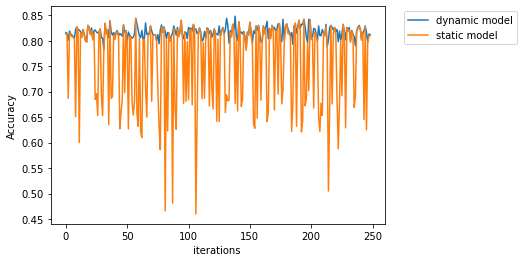

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(0, 249), ACC_Dynmaic, label=f'dynamic model')
plt.plot(range(0,249),ACC_static, label=f'static model')
plt.xlabel('iterations ')
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [22]:
print(f'the maximum accuracy in Dynamic model = {max(ACC_Dynmaic)}')
print(f'the maximum accuracy in Static model = {max(ACC_static)}')

the maximum accuracy in Dynamic model = 0.848
the maximum accuracy in Static model = 0.844
